# Probabilistic polynomial linefitting
This exercise a simple case of linefitting, where we have a set of observations 
$\mathbf{d}_{obs}$ at locations $\mathbf{x}_{obs}$.
We will use the extended Metropolis algorithm to sample from the posterior distribution of the model parameters $m_1$, $m_2$, and $m_3$.

It is expected that the realtion between the position and the data can be described by a 2nd order polynomial, paramterized as $\mathbf{m} = [m_1, m_2, m_3]$, such that forward problem can be described by 

$$ 
  d = g(\mathbf{m},x) = m_1 + m_2 x + m_3 x^2 
$$.


The key question to answer is: What is the probability distribution of the data at x=40, given all the available information?

Two data sets will be considered.
The first data set consists of 5 observations, $\mathbf{d}_{obs_{1}}$, at locations $\mathbf{x}_{obs_{1}}$. Measurement noise is characterized by a Gaussian distribution with zero mean, and standard deviation as given in $\mathbf{d}_{std_{1}}$:
$$
\mathbf{x}_{obs_{1}} =  [2.5593,  14.2569,  15.0507,  19.0726,  26.9363] \\
\mathbf{d}_{obs_{1}} = [2.3911,  -8.1902, -21.9646, -6.3345, 32.5775] \\
\mathbf{d}_{std_{1}} = [8,     8,    40,     8,     8] 
$$
Data are available in the 'linefit_nd05.mat' mat-file.

The second data set consists of 35 observations, $\mathbf{d}_{obs_{2}}$, at locations $\mathbf{x}_{obs_{2}}$. Measurement noise is characterized by a Gaussian distribution with zero mean, and standard deviation as given in $\mathbf{d}_{std_{2}}$. Data are available in the 'linefit_nd35.mat' mat-file.
## Data integration
Both direct and indirect information about $\mathbf{m}$ are available. 

The direct information is given by the prior distribution $f_1(\mathbf{m})$, also referred to as the prior model, which is the probability distribution of the model parameters.

The indirect information $f_2(\mathbf{m})$ represent how well the forward response of a set of model parameters $\mathbf{m}$ explains the observed data. This is also referred to as the likelihood function, which is the probability distribution of the data given the model parameters.
The combined infromation about $\mathbf{m}$ can be obtained by conjunction of $f_1(\mathbf{m})$ and $f_2(\mathbf{m})$, following Tarantola and Valette (1982), as 
$$
   f_{12}(\mathbf{m}) \propto f_1(\mathbf{m}) + f_2(\mathbf{m})
$$
or, using standard Bayesian notation, as  
$$
   \sigma(\mathbf{m}) \propto \rho(\mathbf{m}) + L(\mathbf{m})
$$

## Direct information

The direct information for each of the model parameters is assumed to be independent, such that
$$
f_1(\mathbf{m}) \ = \ f_1(m_1,m_2,m_3) = f_1(m_1) f_1(m_2) f_1(m_3)
$$
The prior information on $m_1$ is 1D Gaussian model, and the prior for $m_2$ and $m_3$ is chosen to be uniformly distributed as:
$$
f_1(m_1)  \propto N(0,10) \\
f_1(m_2)   \propto  U(-10,10) = 1/20 \ \textrm{for}\  -10 \le m_2 \le 10\\
f_1(m_3)  \propto  U(-.1,.1)  =  1/(0.2) \ \textrm{for}\  -0.1 \le m_3 \le 0.1
$$


## Indirect information

$$
f_2(m | d_{obs}) \  =  \Big ( \prod_i \frac{1}{2 \ \sigma^i} \Big ) \ \exp \Bigg ( -\frac{1}{2} \sum_i^N \frac{(d^i - d^i_{obs} )^2}{(\sigma^i)^2}  \Bigg )\\
% = \exp  \Bigg ( -\frac{1}{2} \sum_i \frac{(d^i - d^i_{obs} )^2}{(\sigma^i)^2} \Bigg ) 
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy as sp
import time



In [2]:
def proposal_sample():
    # propose m1, m2, m3
    m1 = np.random.uniform(-30, 30)
    m2 = np.random.uniform(-10, 10)
    m3 = np.random.uniform(-0.1, 0.1)
    return np.array([m1,m2,m3])

def f1_sample():
    m1 = np.random.normal(0, 10)
    m2 = np.random.uniform(-10,10)
    m3 = np.random.uniform(-.1,.1)
    return np.array([m1,m2,m3])


def f1_sample_metropolis(m_current=np.array([0,0,0]), 
                            step=np.array([1, .1 ,.01])):
    
    
    m_propose = m_current.copy() + step * np.random.randn(3)


    f1_cur =  sp.stats.norm.pdf(m_current[0], 0, 10)
    f2_cur=1
    if np.abs(m_current[1])>1:
        f2_cur = 0
    f3_cur=1    
    if np.abs(m_current[2])>.1:
        f3_cur = 0
    f_current = f1_cur*f2_cur*f3_cur

    f1_pro =  sp.stats.norm.pdf(m_propose[0], 0, 10)
    f2_pro=1
    if np.abs(m_propose[1])>1:
        f2_pro = 0
    f3_pro=1
    if np.abs(m_propose[2])>.1:
        f3_pro = 0
    f_propose = f1_pro*f2_pro*f3_pro    

    P_acc = f_propose/f_current
    if np.random.uniform(0, 1) < P_acc:
        m_current = m_propose
            
    return m_current


def forward(m,x_obs):
    d = m[0] + m[1] * x_obs + m[2] * x_obs**2
    return d

def f2_pdf(d, d_obs, d_std):
    useLog = True
    f = -0.5 * np.sum((d_obs - d) ** 2 / (d_std ** 2))
    #f = exp(f)
    return f

def f1_pdf(m):
    fm1 = np.log(norm.pdf(m[0], 0, 10))

    if (m[1] > 10) or (m[1] < -10):
        fm2 = -np.inf
    else:
        fm2 = np.log(1 / 20)

    if (m[2] > 0.1) or (m[2] < -0.1):
        fm3 = -np.inf
    else:
        fm3 = np.log(1 / 0.2)

    f = fm1+fm2+fm3
    return f

def plot_sample_histogram(m_sample, nbins=100):
    plt.figure()

    plt.subplot(3, 1, 1)
    plt.hist(m_sample[:,0], bins=nbins, range=(-35, 35))
    plt.title('m1')

    plt.subplot(3, 1, 2)
    plt.hist(m_sample[:,1], bins=nbins, range=(-12, 12))
    plt.title('m2')

    plt.subplot(3, 1, 3)
    plt.hist(m_sample[:,2], bins=nbins, range=(-0.12, .12))
    plt.title('m3')

    plt.suptitle('1D marginal')

    

def plot_autocorrelation(m_post, maxlags=100, dlag=10):
    nm=m_post.shape[1]
    
    fig, ax = plt.subplots(nm, 1)
    for ix in range(nm):
        #plt.subplot(nm, 1, ix+1)
        ax[ix].acorr(m_post[::dlag, ix]-np.mean(m_post[:,ix]) , usevlines=False, maxlags=maxlags, normed=True, lw=2)
        ax[ix].set_title('m%d'%(ix+1))
        ax[ix].set_ylabel('Normalized \n Autocorrelation')
        ax[ix].grid()
        ax[ix].set_ylim([-.2, 1])
    plt.tight_layout()
    plt.xlabel('Lag (lag-distance=%d)' % dlag)

def plot_sample(m_sample, ax=None):

    nm=m_sample.shape[1]

    # construct ax and fig handle for three subplots
    # if ax is None do next line

    if ax is None:
        fig, ax = plt.subplots(nm, 1)

    for ix in range(nm):
        ax[ix].plot(m_sample[:,ix])
        ax[ix].grid()
        ax[ix].set_ylabel('m%d' % (ix+1) )
    ax[ix].set_xlabel('Iteration/realization number')
    plt.tight_layout()


    return ax

def plot_data(x_obs, d_obs, d_std):
    plt.errorbar(x_obs, d_obs, yerr=2*d_std, fmt='k.', linewidth=2,  label='Observations')
    plt.xlabel('x')
    plt.ylabel('d')
    plt.grid(True)
    plt.xlim([0, 50])



def plot_lines(m_sample, nshow=500):
    n = len(m_sample)
    nshow = min(n, nshow)

    for i in range(0, n, int(n / nshow)):
        d_test = forward(m_sample[i, :], x_test)
        plt.plot(x_test, d_test, 'r-', linewidth=.1)

## Load and plot the data

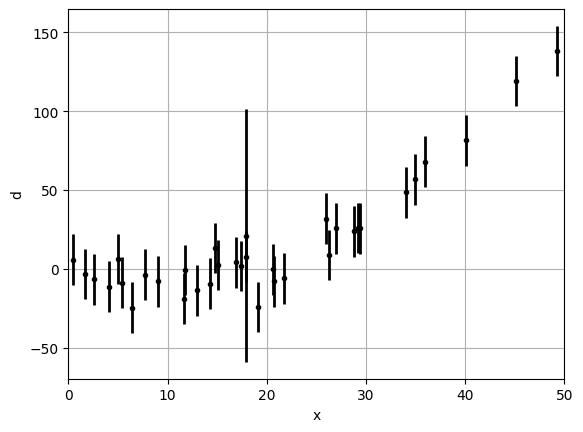

In [3]:
M=sp.io.loadmat('linefit_nd05.mat') # loads the data set with 5 observations
M=sp.io.loadmat('linefit_nd35.mat') # loads the data set with 35 observations

d_obs = np.float32(M['d_obs'].flatten()) # Extract the 1D array from the loaded data
d_std = np.float32(M['d_std'].flatten())
x_obs = np.float32(M['x_obs'].flatten())
x_test = np.arange(0, 50, .1)
nx=len(x_test)
# show the data

plot_data(x_obs, d_obs, d_std)
plt.show()



In [4]:

# generate a sample from f1(m)
m = f1_sample()

# compupte f1(m)
f1 = f1_pdf(m)

# compupte f1(m)
d = forward(m, x_obs)
f2 = f2_pdf(d, d_obs, d_std)

# compute f12(m)
#f12 = f1 + f2 # all pdf valuess are in log space, so we can add them

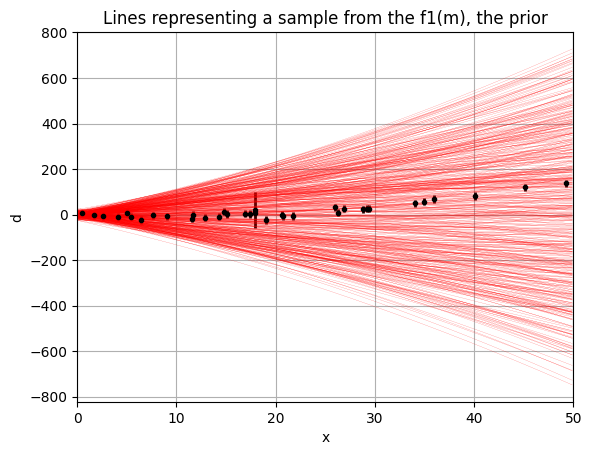

In [5]:

ns=10000
m_prior = np.zeros((ns,3))
d_prior = np.zeros((ns,nx))

for i in range(ns):
    m = f1_sample()
    m_prior[i,:] = m
    d_test = forward(m, x_test)
    d_prior[i,:] = d_test
    d = forward(m, x_obs)



plt.figure(1)
plt.clf()
plot_data(x_obs, d_obs, d_std)
plot_lines(m_prior)
plt.title('Lines representing a sample from the f1(m), the prior')
plt.show()

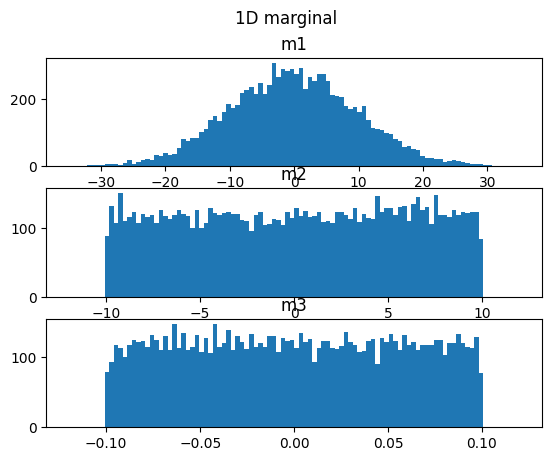

In [6]:
# make histograms of the sample from the proior
plot_sample_histogram(m_prior)

# The Metropolis algorithm


In [7]:

T = 1 # 1 is no annealing
N = 40000 # number of itearations
if len(d_obs)==35:
    step = 0.1*np.array([10,1,.1])
else:
    step = .25*np.array([10,1,.1])

# preallocate memory
m_post = np.zeros((N, 3))
f2_post = np.zeros(N)
f12_post = np.zeros(N)

# Propose a starting model
m_cur = f1_sample()
m_cur = np.array([0,0,0])
d_cur = forward(m_cur, x_obs)
f2_cur = f2_pdf(d_cur, d_obs, d_std)

Nacc = 0
t0=time.time()
for i in range(N):
    
    # Perform a random walk in f1
    m_pro = f1_sample_metropolis(m_cur, step)

    # Compute f2
    d_pro = forward(m_pro, x_obs)
    f2_pro = f2_pdf(d_pro, d_obs, d_std)
    
    # 2c. Accept reject
    P_acc = np.exp(f2_pro - f2_cur) ** (1 / T)
    
    if np.random.rand() < P_acc:
        Nacc += 1

        # accept move and update current model
        m_cur = m_pro.copy()
        d_cur = d_pro.copy()
        f2_cur = f2_pro.copy()
        
    m_post[i,:] = m_cur
    f2_post[i] = f2_cur

    if np.mod(i, 2000) == 0:
        print('i=%5d, Nacc = %4d, AcceptRatio = %f, m_cur=[%f,%f,%f]' %(i,Nacc,Nacc/(i+1),m_cur[0], m_cur[1], m_cur[2]))


t=time.time()-t0
print('Time = %3.1fs.' % t)
print(f'Accepted %d of %d models, PacceptRatio = %5.4f' % (Nacc,N,Nacc/N))
print('%3.1f iterations per accepted model.' % (np.ceil(N/Nacc)))



i=    0, Nacc =    0, AcceptRatio = 0.000000, m_cur=[0.000000,0.000000,0.000000]
i= 2000, Nacc =  699, AcceptRatio = 0.349325, m_cur=[-8.187603,-0.848267,0.076152]
i= 4000, Nacc = 1430, AcceptRatio = 0.357411, m_cur=[-6.274652,-0.957997,0.079560]
i= 6000, Nacc = 2114, AcceptRatio = 0.352275, m_cur=[-8.715208,-0.963116,0.079823]
i= 8000, Nacc = 2823, AcceptRatio = 0.352831, m_cur=[-6.729160,-0.924205,0.076120]
i=10000, Nacc = 3619, AcceptRatio = 0.361864, m_cur=[-5.594527,-0.931472,0.076007]
i=12000, Nacc = 4354, AcceptRatio = 0.362803, m_cur=[-6.776786,-0.937157,0.077509]
i=14000, Nacc = 5086, AcceptRatio = 0.363260, m_cur=[-4.836214,-0.876880,0.075251]
i=16000, Nacc = 5944, AcceptRatio = 0.371477, m_cur=[-8.481184,-0.957401,0.079913]
i=18000, Nacc = 6742, AcceptRatio = 0.374535, m_cur=[-7.050854,-0.909304,0.077271]
i=20000, Nacc = 7478, AcceptRatio = 0.373881, m_cur=[-5.666230,-0.762543,0.071402]
i=22000, Nacc = 8225, AcceptRatio = 0.373847, m_cur=[-7.125936,-0.852623,0.077834]
i=2400

### Analyze the generated model to find the burn-in and the number of independent realizations

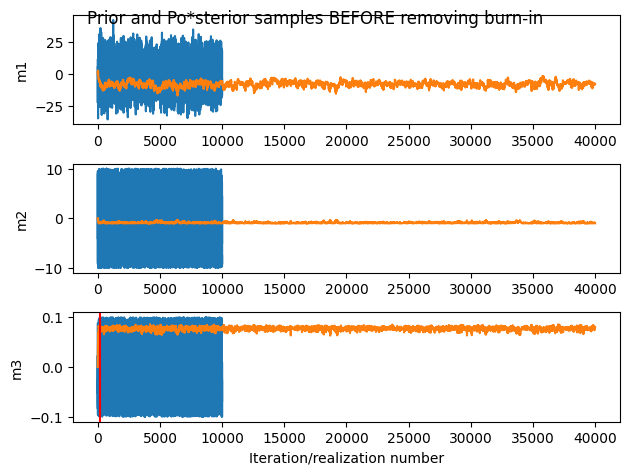

Text(0.5, 1.0, 'f2 values - before removing burn-in')

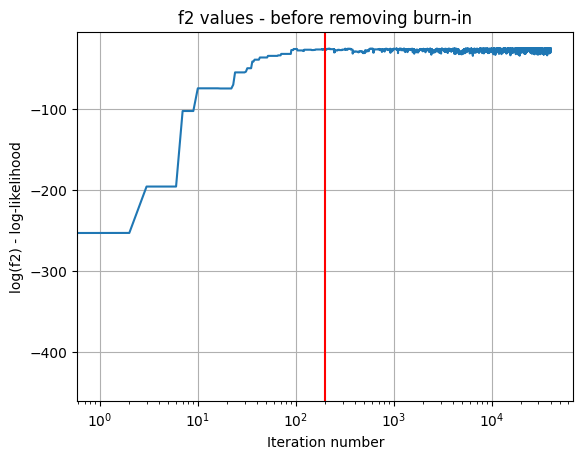

In [8]:
n_burnin = 200

ax = plot_sample(m_prior)
plot_sample(m_post, ax)
plt.axvline(x=n_burnin, color='r')
plt.suptitle('Prior and Po*sterior samples BEFORE removing burn-in')
plt.show()

plt.figure()
plt.semilogx(f2_post)
plt.ylabel('log(f2) - log-likelihood')
plt.xlabel('Iteration number')
plt.axvline(x=n_burnin, color='r')
plt.grid()
plt.title('f2 values - before removing burn-in')



As the burnin is selected to be at n_burnin = {{n_burnin}}, alle realizations before this index will be removed from m_post and f12_post.


In [9]:
m_post = m_post[n_burnin:,:]
f2_post = f2_post[n_burnin:]

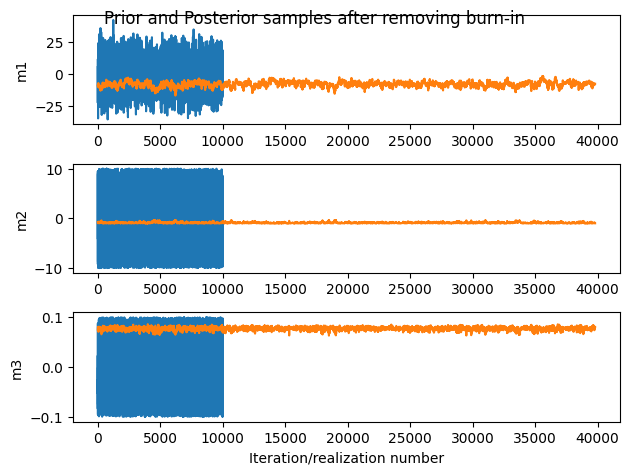

Text(0.5, 1.0, 'f2 values - after removing burn-in')

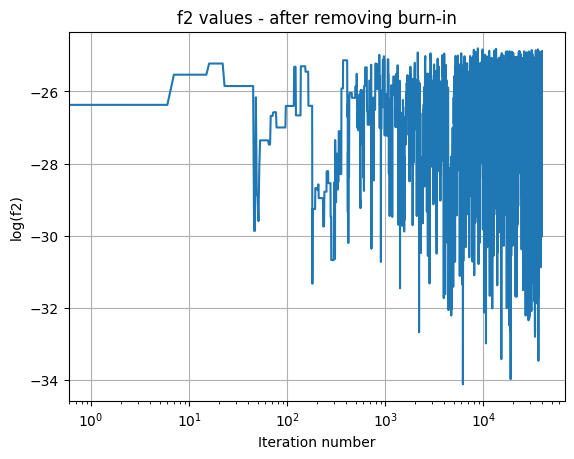

In [10]:

ax = plot_sample(m_prior)
plot_sample(m_post, ax)
plt.suptitle('Prior and Posterior samples after removing burn-in')
plt.show()

plt.figure()
plt.semilogx(f2_post)
plt.ylabel('log(f2)')
plt.xlabel('Iteration number')
plt.grid()
plt.title('f2 values - after removing burn-in')

## Estimate the number of independent realizations
N={{N}} realizations of the posterior distribution have been generated. The next step is to estimate the number of independent realizations. This can be done, for example, by computing the autocorrelation of the realizations of m1, m2, and m3.         

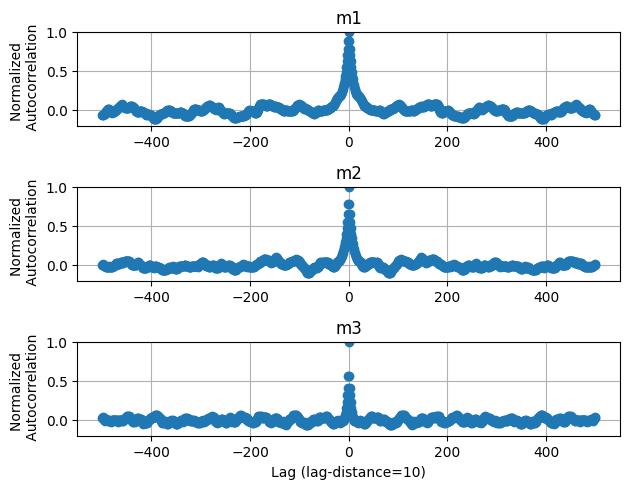

In [11]:
plot_autocorrelation(m_post, maxlags=500)

When the autocorrelation of the realizations of m1, m2, and m3 is close to zero, it suggest the number of iterations need to obtain an independent realization. 
The model parameter with thh longest autocorrelation is should be used for analysis.

If the number of iterations to reach an autocorrelation close to zero is $N_a=100$, then the number of independent realizations is approximately $N_{real}$=$N$/$N_a$.

The number of independent realizations needed depends on the what question is being asked. Here the goal is to approximate the 1D posterior distrution of the data at x=40, and around $N_{real}=1000$ should be sufficient to provide reproducible statistics with a resonable accuracy.

Text(0.5, 0.98, 'f12(m) - Posterior')

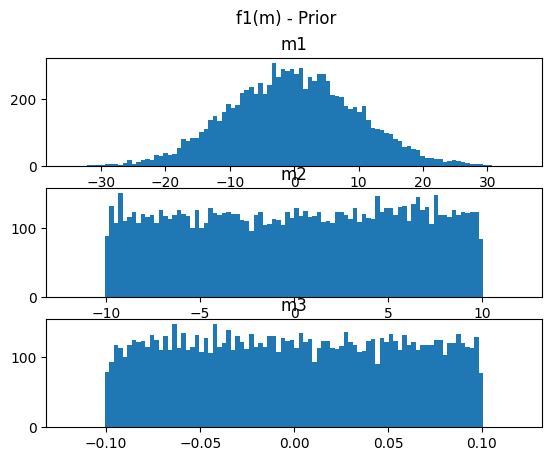

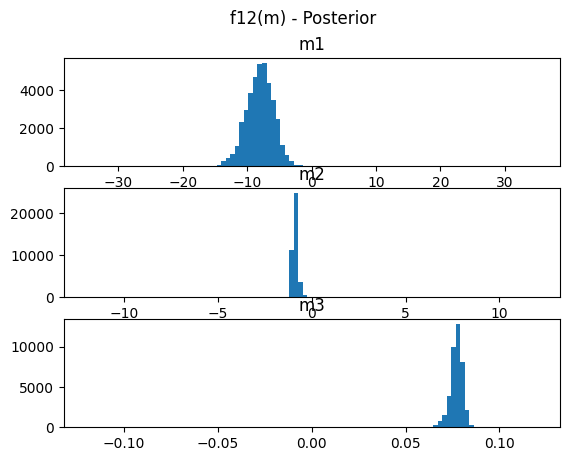

In [12]:
plot_sample_histogram(m_prior)
plt.suptitle('f1(m) - Prior')
plot_sample_histogram(m_post)
plt.suptitle('f12(m) - Posterior')

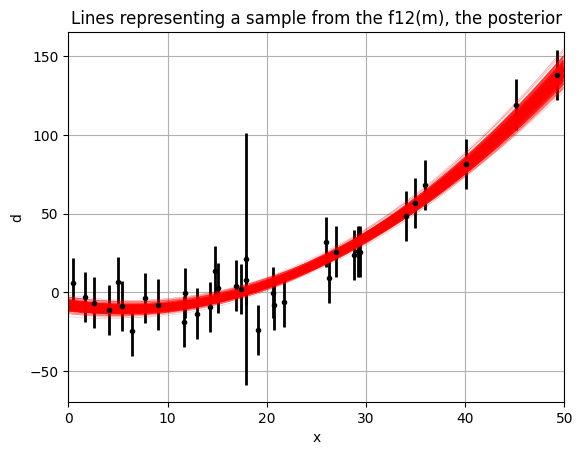

In [13]:

plt.figure(1)
plt.clf()
plot_data(x_obs, d_obs, d_std)
plot_lines(m_post)
plt.title('Lines representing a sample from the f12(m), the posterior')
plt.show()



## Compute the posterior distribution of the data at x=40
At this points a sample of the f12(m) has been generated. Rrealizations of the posterior pre-burnin has been removed, and we should have analyzed abobe that enough independent realizations have been generate to allow compuing the posterior statistics of interest.

Text(0.5, 0.98, 'P(d|x=40) - Prior and Posterior')

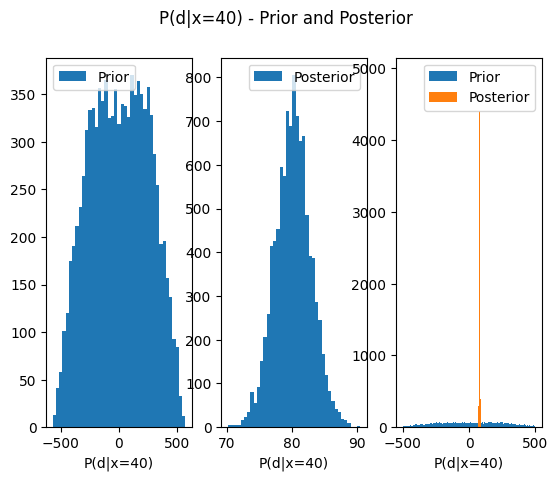

In [14]:
npr=m_prior.shape[0]
d40_prior=np.zeros(npr)
for i in range(npr):
    d40_prior[i]=forward(m_prior[i,:],40)

npo=m_post.shape[0]
d40_post=np.zeros(npr)
i_arr = np.ceil(np.arange(0,npo,npo/npr))
for i in range(npr):
    j=int(i_arr[i])
    d40_post[i]=forward(m_post[j,:],40)

plt.figure(4)
plt.subplot(1, 3, 1)
plt.hist(d40_prior, bins=41, label='Prior')
plt.xlabel('P(d|x=40)')
plt.legend()
plt.subplot(1, 3, 2)
plt.hist(d40_post, bins=41 , label='Posterior')
plt.xlabel('P(d|x=40)')
plt.legend()
plt.subplot(1, 3, 3)
plt.hist(d40_prior, bins=range(-500, 501, 5), label='Prior')
plt.hist(d40_post, bins=range(-500, 501, 5), label='Posterior')
plt.xlabel('P(d|x=40)')
plt.legend()
plt.suptitle('P(d|x=40) - Prior and Posterior')

95pp PRIOR conf interval [-446.4,453.9]
95pp POST conf interval [74.8,85.7]


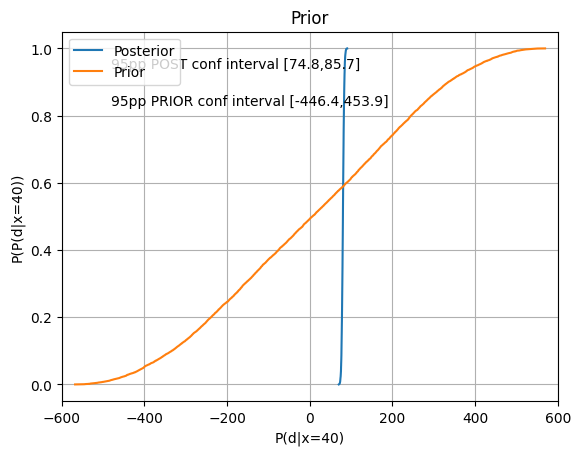

In [15]:

ns = len(d40_prior)
P = np.arange(1, ns + 1) / ns - (1 / (2 * ns))
sd40_prior = np.sort(d40_prior)
pr_p0025 = sd40_prior[int(np.ceil(ns * 0.025))]
pr_p0975 = sd40_prior[int(np.ceil(ns * 0.975))]
pr_txt = '95pp PRIOR conf interval [%3.1f,%3.1f]' % (pr_p0025, pr_p0975 )
print(pr_txt)

ns = len(d40_post)
P = np.arange(1, ns + 1) / ns - (1 / (2 * ns))
sd40 = np.sort(d40_post)
po_p0025 = sd40[int(np.ceil(ns * 0.025))]
po_p0975 = sd40[int(np.ceil(ns * 0.975))]
po_txt = '95pp POST conf interval [%3.1f,%3.1f]' % (po_p0025, po_p0975 )
print(po_txt)

plt.figure(5)
plt.plot(sd40, P, label='Posterior')
plt.xlabel('P(d|x=40)')
plt.ylabel('P(P(d|x=40))')
plt.legend()
plt.text(.1, .9, po_txt, transform=plt.gca().transAxes)
plt.title('Posterior')
plt.xlim([-600, 600])
plt.savefig(f'linefitA_N{len(d_obs)}_p40.png')

#plt.figure(6)
plt.plot(sd40_prior, P, label='Prior')
plt.xlabel('P(d|x=40)')
plt.ylabel('P(P(d|x=40))')
plt.text(.1, .8, pr_txt, transform=plt.gca().transAxes)
plt.title('Prior')
plt.xlim([-600, 600])
plt.grid()
plt.legend()
plt.savefig(f'linefitA_N{len(d_obs)}_p40_prior.png')

In [16]:
d_thres=77
P_prior = np.sum(d40_prior < d_thres) / len(d40_prior)
P_post = np.sum(d40_post < d_thres) / len(d40_post)
print('P(d<%3.1f | f1,prior) = %5.4f' % (d_thres, P_prior))
print('P(d<%3.1f | f12,post) = %5.4f' % (d_thres, P_post))

P(d<77.0 | f1,prior) = 0.5853
P(d<77.0 | f12,post) = 0.1284
